<div style="text-align: center; font-family: 'Georgia', serif; color: #4b0082; padding: 20px; border: 2px solid #4b0082; border-radius: 10px; background-color: #f0f8ff;">
    <h1 style="font-size: 2.5em;">Stochastic Processes Project</h1>
    <h2 style="font-size: 1.5em;">Jean Duboscq (3175875)</h2>
    <h2 style="font-size: 1.5em;">Keshav Ganesh (3174597)</h2>
    <h2 style="font-size: 1.5em;">Daniyar Zakarin (3190014)</h2>
    <h3 style="font-size: 2em; margin-top: 20px;">Project 10: Particle Diffusion in a Circular Domain</h3>
</div>



### Description

Escape of a particle from an intracellular region: A particle is diffusing according to Brownian motion in a 2D circular domain of radius $r$. The particle can only exit the domain from an opening defined by a segment of a circle of angular width $\theta$.

We investigate the mean exit time of the domain as a function of the angular width $\theta$.

### Mathematical Formalism

- **Brownian Motion**: The particle's position follows a Brownian motion, described by the stochastic differential equation:
  $
  d\mathbf{X}(t) = \sqrt{2D} \, d\mathbf{W}(t)
  $
  where $ \mathbf{X}(t) $ is the position of the particle at time $ t ,   D  $ is the diffusion coefficient, and $\mathbf{W}(t) $ is a Wiener process.

- **Domain**: The particle moves within a circular domain of radius $ r $. The boundary conditions ensure that the particle reflects off the circle's boundary, except for an opening of angular width $ \theta $, where the particle can escape.

- **Exit Time**: The mean exit time $ T(\theta) $ is the expected time for the particle to leave the domain through the opening.

### Summary of Work

1. **Simulation Setup**:
   - Implemented the basic simulation environment with fixed parameters: $ r = 1 , D = 1 $, and initial position $ \mathbf{X}(0) = (0, 0) $.
   - Developed a function to handle boundary reflections.

2. **Visualization**:
   - Plotted random paths of particles to visualize the diffusion process.
   - Demonstrated the reflection mechanism through graphical plots.

3. **Mean Exit Time Analysis**:
   - Analyzed the mean exit time as a function of $ \theta $.
   - Attempted to fit the mean exit time data to analytical models, including an exponential decay function and an inverse linear function.

4. **Histogram of Exit Times**:
   - Created histograms to represent the distribution of exit times for fixed $ \theta $.
   - Compared the empirical distribution with theoretical models like the Lévy distribution.

5. **Density Plots**:
   - Simulated the distribution of multiple particles over time to observe the spreading pattern from the initial position.

This comprehensive study helps us understand how the angular width of the opening influences the mean exit time of particles undergoing Brownian motion within a circular domain.


## General Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import datetime
from scipy.stats import linregress


eps = 1e-6


### Basic Implementation

In this section, we set up the basic simulation environment for our particle diffusion model. We fix the radius of the circle to be 1 and the diffusion coefficient to be 1. The following parameters are used for the simulation:

- $ r = 1 $: Radius of the circular domain.
- $ D = 1 $: Diffusion coefficient.
- Initial position $ x_0 = (0, 0) $: The starting point of the particle.

For the initial experiments, we set the angular width $ \theta $ to be $ \pi/4 $ to observe the general behavior of the particles.


## Experiment Class

The `Experiment` class defines the parameters and initial conditions for the particle diffusion simulation. 

### Attributes:
- `r`: Radius of the circle in which the particles are diffusing. Default value is 1.0.
- `theta`: Angular width of the exit (missing arc) in the circle. Default value is π/4.
- `D`: Diffusion constant representing the rate at which particles diffuse. Default value is 1.0.
- `dt`: Time step for the simulation. Default value is 0.01.
- `num_particles`: Number of particles to simulate. Default value is 10,000.
- `x_start`: Starting x-coordinate for the particles. Default value is 0.0.
- `y_start`: Starting y-coordinate for the particles. Default value is 0.0.
- `T_lim`: Time limit for the simulation. Default value is 10,000.

In [4]:
class Experiment:
    def __init__(self, r = 1.0, theta = np.pi / 4, 
                 D = 1.0, dt = 0.01, num_particles = 10000, 
                 x_start = 0.0, y_start = 0.0, T_lim = 10000.):
        self.r = r # radius of the circle
        self.theta = theta # exit angular width
        self.D = D # diffusion constant
        self.dt = dt # number of particles to simulate
        self.num_particles = num_particles # number of particles to simulate
        self.x_start = x_start # starting x coordinate
        self.y_start = y_start # starting y coordinate
        self.T_lim = T_lim
E = Experiment

In [5]:
# Parameters
default_experiment = E(
    r = 1.0, 
    theta = np.pi / 4, 
    D = 1.0, 
    dt = 0.01, 
    num_particles = 10000, 
    x_start = 0.0, 
    y_start = 0.0
)

## Intersection Finding Function

The `find_intersection` function determines the intersection point between the path of a particle and the boundary of a circle. This is useful for simulating particle movement and checking if a particle has escaped the circular region.

### Parameters:
- `x`: Current x-coordinate of the particle.
- `y`: Current y-coordinate of the particle.
- `x_prev`: Previous x-coordinate of the particle.
- `y_prev`: Previous y-coordinate of the particle.
- `r`: Radius of the circle.

### Returns:
- `(x_int, y_int)`: Coordinates of the intersection point if it exists. If no intersection is found within the valid range, it returns `(None, None)`.


In [6]:
def find_intersection(x, y, x_prev, y_prev, r):
    x_prev_norm_squared = x_prev**2 + y_prev**2
    x_norm_squared = x**2 + y**2
    dot_product = x_prev * x + y_prev * y
    
    a = x_prev_norm_squared + x_norm_squared - 2 * dot_product
    b = 2 * dot_product - 2 * x_norm_squared
    c = x_norm_squared - r**2

    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return None, None
    
    lambda_1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    lambda_2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)

    if 0 < lambda_1 < 1:
        x_int = x + lambda_1 * (x_prev - x)
        y_int = y + lambda_1 * (y_prev - y)
    elif 0 < lambda_2 < 1:
        x_int = x + lambda_2 * (x_prev - x)
        y_int = y + lambda_2 * (y_prev - y)
    else:
        return None, None
    return x_int, y_int

## Exit Segment Check Function

The `is_in_exit_segment` function determines if the intersection point between a particle's path and the circle boundary lies within the defined exit segment (missing arc).

### Parameters:
- `x`: Current x-coordinate of the particle.
- `y`: Current y-coordinate of the particle.
- `x_prev`: Previous x-coordinate of the particle.
- `y_prev`: Previous y-coordinate of the particle.
- `theta`: Angular width of the exit segment (missing arc).
- `r`: Radius of the circle.

### Returns:
- `bool`: `True` if the intersection point is within the exit segment, `False` otherwise.


In [7]:
def is_in_exit_segment(x, y, x_prev, y_prev, theta, r):
    # find intersection point
    x_int, y_int = find_intersection(x, y, x_prev, y_prev, r)
    if x_int is None:
        return False
    
    # check if intersection point is in the exit segment
    return -theta/2 < np.arctan2(y_int, x_int) < theta / 2 

## Reflection and Brownian Motion Functions

These functions handle the reflection of particles and their Brownian motion within a circular boundary with a missing arc.



### Reflect Function

The `reflect` function calculates the new position of a particle after it reflects off the boundary of the circle.

#### Parameters:
- `x`: Current x-coordinate of the particle.
- `y`: Current y-coordinate of the particle.
- `x_prev`: Previous x-coordinate of the particle.
- `y_prev`: Previous y-coordinate of the particle.
- `r`: Radius of the circle.

#### Returns:
- `(x_reflection, y_reflection)`: Coordinates of the particle after reflection.


In [8]:
def reflect(x, y, x_prev, y_prev, r):
    # Calculate the coefficients of the quadratic equation
    x_intersection, y_intersection = find_intersection(x, y, x_prev, y_prev, r)
    if x_intersection is None:
        raise ValueError("No intersection point found")
    
    # Calculate the normal vector at the intersection point
    normal_x = x_intersection / r
    normal_y = y_intersection / r
    
    # Calculate the incident vector
    incident_x = x - x_intersection
    incident_y = y - y_intersection
    
    # Reflect the incident vector across the normal vector
    dot_product = incident_x * normal_x + incident_y * normal_y
    reflection_x = incident_x - 2 * dot_product * normal_x
    reflection_y = incident_y - 2 * dot_product * normal_y
    
    # Calculate the reflected position
    x_reflection = x_intersection + reflection_x
    y_reflection = y_intersection + reflection_y
    
    return x_reflection, y_reflection


### Brownian Motion Functions

#### `brownian_step`

This function simulates a single Brownian step for a particle within the circular region and handles its reflection if it hits the boundary.

##### Parameters:
- `x`: Current x-coordinate of the particle.
- `y`: Current y-coordinate of the particle.
- `experiment`: An instance of the `Experiment` class containing simulation parameters.

##### Returns:
- `(x, y)`: New coordinates of the particle after the Brownian step.



In [ ]:

def brownian_step(x, y, experiment):
    x_prev, y_prev = x, y
    D = experiment.D
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r
    
    # Brownian motion: update position with random steps
    step_size = np.sqrt(2 * D * dt)
    dx = step_size * np.random.randn()
    dy = step_size * np.random.randn()
    x_new = x + dx
    y_new = y + dy
    
    # Check if particle is outside the circle
    if x_new**2 + y_new**2 > r**2:
        if is_in_exit_segment(x_new, y_new, x_prev, y_prev, theta, r):
            x, y = x_new, y_new
        else:
            # Reflect the particle back
            try:
                x, y = reflect(x_new, y_new, x, y, r)
            except ValueError:
                # Handle the case where reflection calculation fails
                x, y = x_prev, y_prev  # Reset to previous position
    else:
        x, y = x_new, y_new
    return x, y



#### `brownian_step_escaped`

This function simulates a single Brownian step for a particle that has escaped the circular region and handles its reflection if it hits the boundary.

##### Parameters:
- `x`: Current x-coordinate of the particle.
- `y`: Current y-coordinate of the particle.
- `experiment`: An instance of the `Experiment` class containing simulation parameters.

##### Returns:
- `(x, y)`: New coordinates of the particle after the Brownian step.


In [ ]:

def brownian_step_escaped(x, y, experiment):
    x_prev, y_prev = x, y
    D = experiment.D
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r
    
    # Brownian motion: update position with random steps
    step_size = np.sqrt(2 * D * dt)
    dx = step_size * np.random.randn()
    dy = step_size * np.random.randn()
    x_new = x + dx
    y_new = y + dy

    # Check if particle is outside the circle
    if x_new**2 + y_new**2 < r**2 + eps:
        if is_in_exit_segment(x_new, y_new, x, y, theta, r):
            x, y = x_new, y_new
        else:
            # Reflect the particle back
            try:
                x, y = reflect(x_new, y_new, x, y, r)
            except ValueError:
                # Handle the case where reflection calculation fails
                x, y = x_prev, y_prev  # Reset to previous position
    else:
        x, y = x_new, y_new

    return x, y


Here we plot a graph to display how our reflect function works. We can see that the particle is reflected off the boundary of the circle.

0.0 1.0


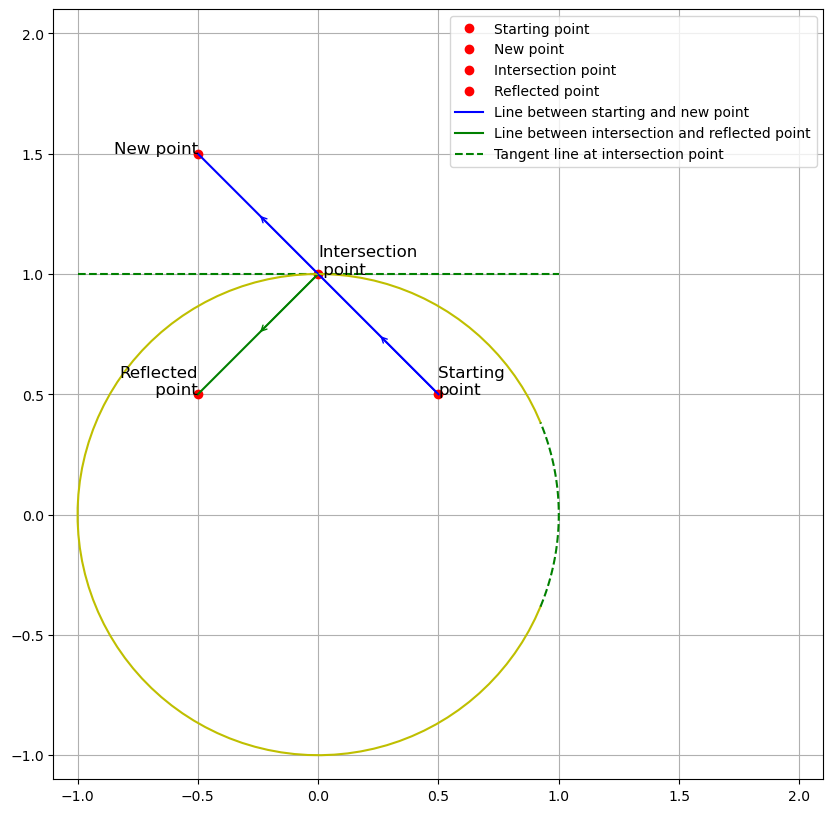

In [9]:
def reflect_func(experiment):
    x_start = 0.5
    y_start = 0.5

    x_new = -0.5
    y_new = 1.5

    x_int, y_int = find_intersection(x_new, y_new, x_start, y_start, experiment.r)
    print(x_int, y_int)
    x_reflected, y_reflected = reflect(x_new, y_new, x_start, y_start, experiment.r)

    fig, ax = plt.subplots(figsize=(15, 10))   

    # mark particle points, write label next to them
    ax.plot(x_start, y_start, 'ro', label='Starting point')
    ax.text(x_start, y_start, 'Starting \npoint', fontsize=12, ha='left')
    ax.plot(x_new, y_new, 'ro', label='New point')
    ax.text(x_new, y_new, 'New point', fontsize=12, ha='right')
    ax.plot(x_int, y_int, 'ro', label='Intersection point')
    ax.text(x_int, y_int, 'Intersection\n point', fontsize=12, ha='left')
    ax.plot(x_reflected, y_reflected, 'ro', label='Reflected point')
    ax.text(x_reflected, y_reflected, 'Reflected\n point', fontsize=12, ha='right')

    # draw line between points
    ax.plot([x_start, x_new], [y_start, y_new], 'b-', label='Line between starting and new point')
    ax.plot([x_int, x_reflected], [y_int, y_reflected], 'g-', label='Line between intersection and reflected point')

    # draw arrows in the middle of the lines
    ax.annotate('', xy=(0.5*x_start + 0.5*x_int, 0.5*y_start + 0.5*y_int), xytext=(x_start, y_start), arrowprops=dict(arrowstyle='->', color='b'))
    ax.annotate('', xy=(0.5*x_int + 0.5*x_new, 0.5*y_int + 0.5*y_new), xytext=(x_start, y_start), arrowprops=dict(arrowstyle='->', color='b'))
    ax.annotate('', xy=(0.5*x_reflected + 0.5*x_int, 0.5*y_reflected + 0.5*y_int), xytext=(x_int, y_int), arrowprops=dict(arrowstyle='->', color='g'))
    
    # draw tangent line at intersection point
    ax.plot([x_int - y_int, x_int + y_int], [y_int + x_int, y_int - x_int], 'g--', label='Tangent line at intersection point')

    theta = experiment.theta
    r = experiment.r
    margin = 0.1 * r

    # Define the circle with a missing arc
    theta_start = theta / 2.  # Start angle for the arc (in radians)
    theta_end = 2 * np.pi - theta / 2.  # End angle for the arc (in radians)

    # Create the solid arc
    arc_solid = np.linspace(theta_start, theta_end, 100)
    circle_x_solid = r * np.cos(arc_solid)
    circle_y_solid = r * np.sin(arc_solid)

    # Create the dotted arc for the missing segment
    arc_dotted = np.linspace(theta_end, 2 * np.pi + theta_start, 100)
    circle_x_dotted = r * np.cos(arc_dotted)
    circle_y_dotted = r * np.sin(arc_dotted)

    # Plot the solid arc
    ax.plot(circle_x_solid, circle_y_solid, color='y')

    # Plot the dotted arc
    ax.plot(circle_x_dotted, circle_y_dotted, 'g--')

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set the limits to create a box from (-r, -r) to (r, r)
    ax.set_xlim(-r - margin, 2*r + margin)
    ax.set_ylim(-r - margin, 2*r + margin)

    # Add grid lines for better visualization
    ax.grid(True)

    ax.legend()

    # Display the plot
    plt.show()
    
reflect_func(E())

## Particle Simulation Function

The `simulate_particle` function simulates the movement of a single particle within a circular region with a missing arc, tracking the time it takes for the particle to escape the circle.

### Parameters:
- `experiment`: An instance of the `Experiment` class containing simulation parameters.

### Returns:
- `time`: The time it takes for the particle to escape the circle. If the particle does not escape within the time limit, it returns `None`.


In [13]:
def simulate_particle(experiment):
    # Start at the center
    x, y = experiment.x_start, experiment.y_start
    time = 0.0
    
    D = experiment.D 
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r 

    while time < experiment.T_lim:
        x, y = brownian_step(x, y, experiment)  
        time += dt
        if x**2 + y**2 > r**2:      
            return time
    return None

### Plot random paths

We write a function to plot the random paths of a particle in the circle. 

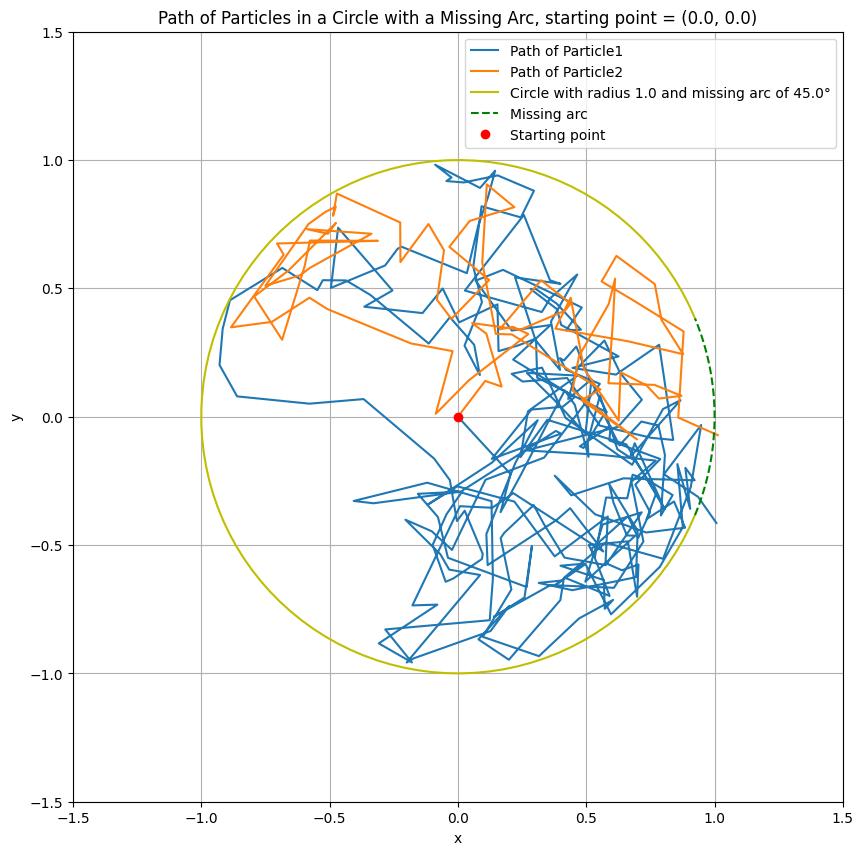

In [193]:
def plot_path(experiment):
    theta = experiment.theta   
    r = experiment.r
    margin = 0.5 * r
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(f'Path of Particles in a Circle with a Missing Arc, starting point = {experiment.x_start, experiment.y_start}')
    plt.xlabel('x')
    plt.ylabel('y')
    

    # Plot the path of the particles
    for _ in range(experiment.num_particles):
        x, y = experiment.x_start, experiment.y_start
        x_prev, y_prev = x, y
        x_path = [x]
        y_path = [y]
        time = 0.0
        while time < experiment.T_lim:
            x, y = brownian_step(x, y, experiment)
            x_path.append(x)
            y_path.append(y)
            time += experiment.dt
            if x**2 + y**2 > r**2:
                break
        plt.plot(x_path, y_path, label=f'Path of Particle{_+1}')
    
    # Define the circle with a missing arc
    theta_start = theta / 2.  # Start angle for the arc (in radians)
    theta_end = 2 * np.pi - theta / 2.  # End angle for the arc (in radians)

    # Create the solid arc
    arc_solid = np.linspace(theta_start, theta_end, 100)
    circle_x_solid = r * np.cos(arc_solid)
    circle_y_solid = r * np.sin(arc_solid)

    # Create the dotted arc for the missing segment
    arc_dotted = np.linspace(theta_end, 2 * np.pi + theta_start, 100)
    circle_x_dotted = r * np.cos(arc_dotted)
    circle_y_dotted = r * np.sin(arc_dotted)

    # Plot the solid arc
    ax.plot(circle_x_solid, circle_y_solid, color='y', label=f'Circle with radius {r} and missing arc of {theta * 180 / np.pi:.1f}°')

    # Plot the dotted arc
    ax.plot(circle_x_dotted, circle_y_dotted, 'g--', label='Missing arc')

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set the limits to create a box from (-r, -r) to (r, r)
    ax.set_xlim(-r - margin, r + margin)
    ax.set_ylim(-r - margin, r + margin)

    # Add grid lines for better visualization
    ax.grid(True)

    #highlight starting point
    ax.plot(experiment.x_start, experiment.y_start, 'ro', label='Starting point')

    ax.legend()
    # Display the plot
    plt.show()
        
# Plot the path of a particle

experiment = E(theta=np.pi/4, num_particles=2, D=1.0)
plot_path(experiment)

We plot the random path of the particle also starting at (0.5,0.5) to see how the particle moves.

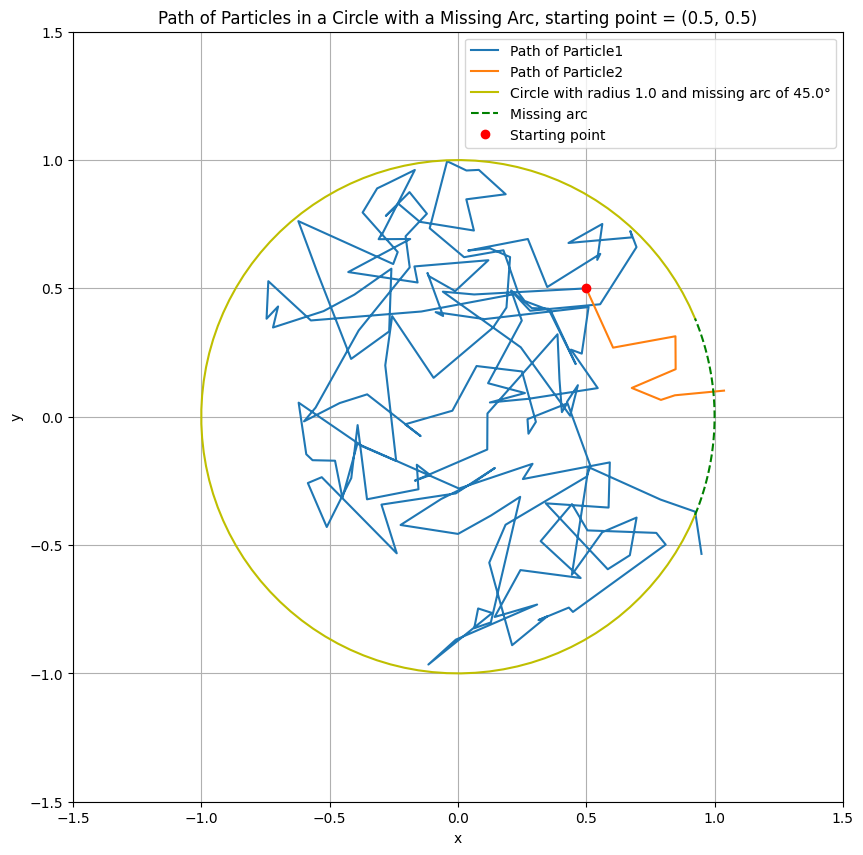

In [194]:
experiment = E(theta=np.pi/4, num_particles=2, D=1.0, x_start=0.5, y_start=0.5)
plot_path(experiment)

## Mean exit time analysis

We simulate the mean exit time for a large number of particles to understand their behavior within a circle with a missing arc.

In [146]:
mean_exit_times = [simulate_particle(default_experiment) for _ in range(default_experiment.num_particles)]
mean_exit_time = np.mean(mean_exit_times)
print(f"Mean exit time (discretized with Brownian motion and elastic reflection): {mean_exit_time}")

Mean exit time (discretized with Brownian motion and elastic reflection): 2.2679979999999818


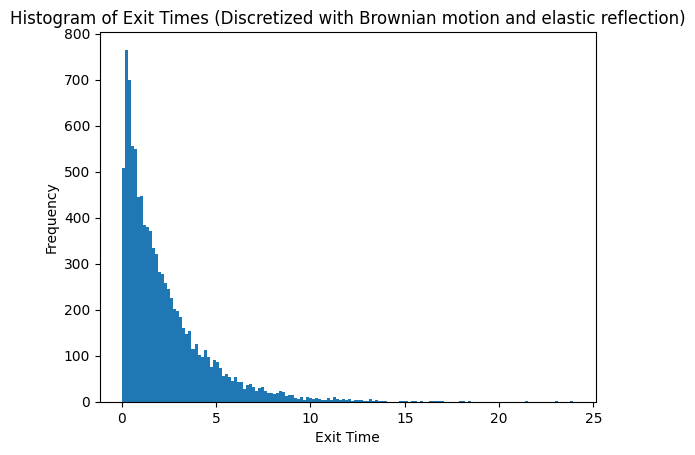

In [147]:
# Plot histogram of exit times
plt.hist(mean_exit_times, bins=150)
plt.xlabel('Exit Time')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Times (Discretized with Brownian motion and elastic reflection)')
plt.show()

Now, we alter the parameter $\theta$ to see how the mean exit time changes.

In [11]:
def mean_exit_time_theta(experiment):
    x_start = experiment.x_start
    y_start = experiment.y_start 
    theta = experiment.theta
    num_particles = experiment.num_particles 
    
    mean_exit_times = [simulate_particle(E(theta=theta, x_start=x_start, y_start=y_start)) for _ in range(num_particles)]
    mean_exit_time = np.mean(mean_exit_times)
    return mean_exit_time

Time taken to run simulation with different theta values: 142.19080805778503 seconds
[4.801980999999962, 3.276215999999968, 2.625478999999976, 2.191859999999982, 1.9087109999999865, 1.6736339999999899, 1.5094939999999921, 1.3455059999999939, 1.2263979999999954, 1.1231749999999963, 1.0183389999999974, 0.9103399999999984, 0.8408159999999987, 0.7828739999999992, 0.7101369999999995, 0.6582799999999996, 0.6040289999999998, 0.5689699999999999, 0.5246970000000001, 0.4810530000000002, 0.4505780000000001, 0.42038600000000015, 0.3868130000000002, 0.36856100000000014, 0.34138700000000016, 0.33553700000000014, 0.3184230000000001, 0.3062100000000001, 0.2978460000000001, 0.29323700000000014]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44362175 5.65351264 5.86340353 

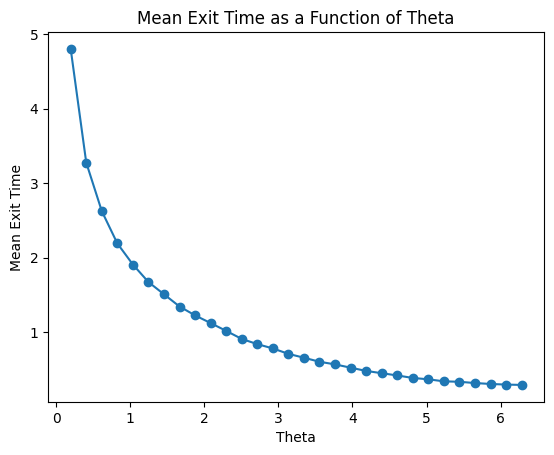

In [149]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

The mean exit time seems to decay at an exponential-like rate.
The asymptote is well-defined beyond $\theta > 2\pi$, indicating no boundaries.
As $\theta$ approaches $0$, the mean exit time should go to $\rightarrow \infty$ since the particles never leave the circle.

Here, we not only alter the parameter $\theta$, but also the starting position of the particle. We will see how the mean exit time changes with the starting position of the particle.

Time taken to run simulation with different theta values and starting position = (0.5,0.5): 97.54851698875427 seconds


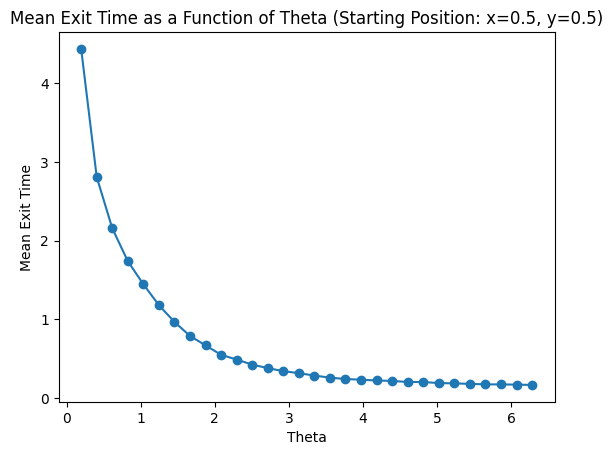

In [150]:
# change starting position of particles
mean_exit_times_theta_list = []
start_time = time.time()
for theta in theta_values:
    experiment = Experiment(theta = theta, num_particles = 10000, x_start = 0.5, y_start = 0.5)
    mean_exit_times_theta_list.append(mean_exit_time_theta(experiment))
end_time = time.time()
print(f"Time taken to run simulation with different theta values and starting position = (0.5,0.5): {end_time - start_time} seconds")

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta (Starting Position: x=0.5, y=0.5)')
plt.show()

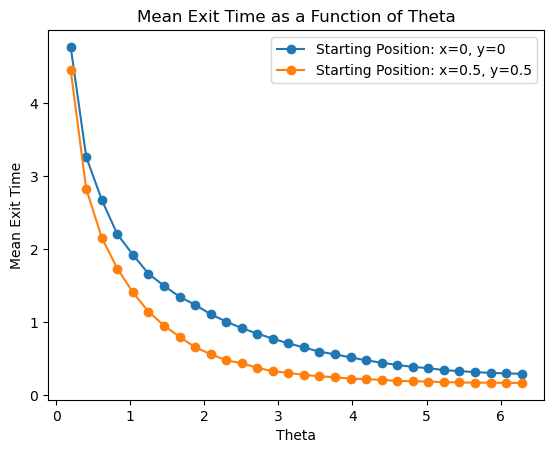

In [14]:
# plot both curves
theta_values = np.linspace(np.pi/16, 2*np.pi, 30)
mean_exit_times_theta_list_moved = [mean_exit_time_theta(E(theta = theta, num_particles=10000, x_start=0.5, y_start=0.5)) for theta in theta_values]
mean_exit_times_theta_list = [mean_exit_time_theta(E(theta=theta, num_particles=10000)) for theta in theta_values]

plt.plot(theta_values, mean_exit_times_theta_list, marker='o', label='Starting Position: x=0, y=0')
plt.plot(theta_values, mean_exit_times_theta_list_moved, marker='o', label='Starting Position: x=0.5, y=0.5')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.legend()
plt.show()

Intuitively, we expect the mean exit time for the particle starting at (0.5,0.5) will be lower because it is closer to the opening.

## Fitting Different Decay functions to the mean exit time

Empirically, we observe a decay, and it is interesting to see how the rate depends on the size of the exit segment. We tried fitting different functions, and the best fit was an inverse linear function.

We try to fit this function to the mean exit time function
\begin{equation}
T(\theta) = \beta e^{\alpha / \theta}
\end{equation}

We chose this one because of the exponential decay and clearly defined horizontal asymptote like the one we observe in our graphs.

In [271]:
def fit_min_exit_time_to_exp(theta_vals, mean_exit_time_vals):
    my_theta_vals = np.array(theta_vals)
    my_mean_exit_time_vals = np.array(mean_exit_time_vals)

    x = 1 / my_theta_vals
    y = np.log(my_mean_exit_time_vals)

    # Step 3: Use linregress to find the slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    alpha = slope 
    beta = np.exp(intercept)
    return alpha, beta

0.6083530268701564 0.5192810677166473
Time taken to run simulation with different theta values: 49.34588432312012 seconds
[4.652655999999959, 3.244538999999967, 2.5632949999999766, 2.175579999999983, 1.881732999999987, 1.6848109999999898, 1.4841629999999923, 1.3448729999999942, 1.227317999999995, 1.1157899999999965, 1.0043569999999975, 0.9351009999999981, 0.8392119999999986, 0.7607329999999991, 0.7069919999999995, 0.6456379999999997, 0.6023369999999999, 0.5537040000000001, 0.5071490000000001, 0.47117300000000023, 0.44061900000000026, 0.41995000000000016, 0.39148200000000016, 0.3680220000000001, 0.3490230000000002, 0.33379400000000015, 0.31866900000000004, 0.30339300000000013, 0.3007040000000001, 0.2958450000000001]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.2337

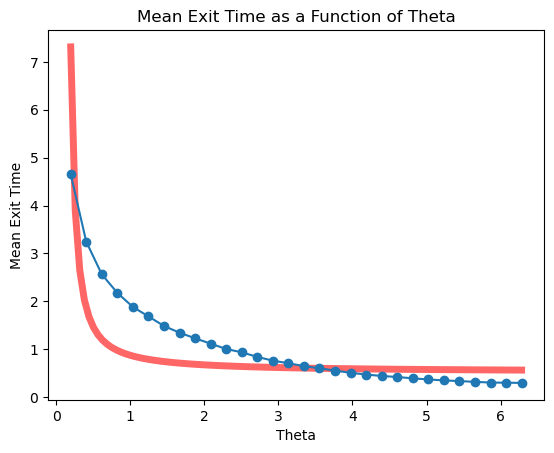

In [276]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_exp(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta * np.exp(beta / x),
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

- **Fit Quality:** While the exponential decay function fits the general trend of the data, it appears to decay too quickly in the initial segment (near $\theta = 0$). This suggests that the function might not perfectly capture the dynamics of the system for very small exit segments.
- **Implications:** The rapid decay highlights the sensitivity of the mean exit time to small changes in $\theta$, which could be crucial for understanding diffusion processes in constrained geometries. However, the overly fast decay in the fit indicates that there might be more complexity in the system that the current model doesn't fully capture.


### Inverse Linear

Although it has a horizontal asymptote, the inverse linear function has a smaller decay rate. It turns out to be a pretty good fit for the observed data.
\begin{equation}
    T(\theta) = \beta + \frac{\alpha}{\theta}
\end{equation}

In [284]:
from scipy.optimize import curve_fit

def fit_min_exit_time_to_inv_linear(theta_vals, mean_exit_time_vals):
    my_theta_vals = np.array(theta_vals)
    my_mean_exit_time_vals = np.array(mean_exit_time_vals)

    x = 1 / my_theta_vals
    y = my_mean_exit_time_vals

    # Step 3: Use linregress to find the slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    alpha = slope 
    beta = intercept
    return alpha, beta

0.9603724566633827 0.43373437871169873
Time taken to run simulation with different theta values: 49.462323904037476 seconds
[4.630552999999961, 3.1502539999999692, 2.5508549999999772, 2.1572829999999827, 1.9160469999999867, 1.6769069999999902, 1.4898019999999923, 1.3394319999999942, 1.2277189999999951, 1.0880839999999965, 0.9962579999999974, 0.9150159999999982, 0.8438809999999987, 0.7687909999999992, 0.7275759999999994, 0.6497929999999996, 0.6044989999999999, 0.552826, 0.52054, 0.48250200000000015, 0.4421420000000002, 0.4059690000000002, 0.39083500000000015, 0.36682000000000015, 0.3441730000000001, 0.33121000000000017, 0.32054500000000014, 0.3051520000000002, 0.30050100000000013, 0.29565300000000005]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44362175

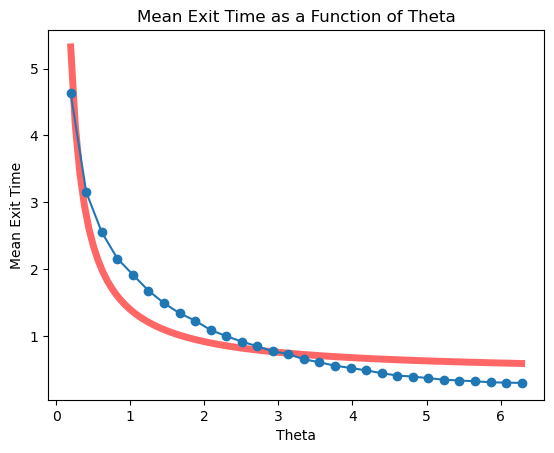

In [282]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

- **Decay Rate:** The inverse linear function shows a more gradual decay compared to the exponential decay function. This better matches the behavior of the simulated data, especially for small values of $\theta$.
- **Asymptotic Behavior:** As $\theta$ increases, the mean exit time approaches a horizontal asymptote, indicating that the effect of increasing $\theta$ diminishes. This behavior is consistent with the physical intuition of the problem.
- **Fit Quality:** The inverse linear function provides a good fit to the data across the entire range of $\theta$ values. It captures the rapid initial decay and the gradual approach to the asymptote more accurately than the exponential decay function.

Overall, the inverse linear function offers a more accurate representation of the mean exit time as a function of $\theta$, balancing both the decay rate and the asymptotic behavior effectively.

## Using the `curve_fit` Method for Better Fitting

Let's use the `curve_fit` method instead of manual fitting to achieve a more accurate fit for the decay function. This approach leverages the optimization capabilities of `curve_fit` to fine-tune the parameters for the best fit.


In [ ]:

def fit_min_exit_time_to_inv_linear_with_curvefit(theta_vals, mean_exit_time_vals):
    def formula(x, alpha, beta):
        return beta + alpha / x
    
    params, covariance = curve_fit(formula, theta_vals, mean_exit_time_vals)
    alpha, beta = params
    return alpha, beta

0.9578588725370406 0.4343561065718333
Time taken to run simulation with different theta values: 46.6053671836853 seconds
[4.609769999999962, 3.159815999999968, 2.5647269999999773, 2.159324999999983, 1.8632929999999872, 1.6824189999999901, 1.5045399999999922, 1.358819999999994, 1.2111269999999956, 1.1176969999999964, 0.9915279999999977, 0.9014269999999985, 0.8387399999999987, 0.767757999999999, 0.7138259999999995, 0.6496969999999996, 0.6089059999999997, 0.559756, 0.5181720000000001, 0.4746750000000002, 0.44567300000000015, 0.41586500000000015, 0.38876100000000013, 0.36105700000000013, 0.34853900000000015, 0.32718600000000014, 0.3141080000000001, 0.30303800000000014, 0.30110800000000015, 0.29976400000000014]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44

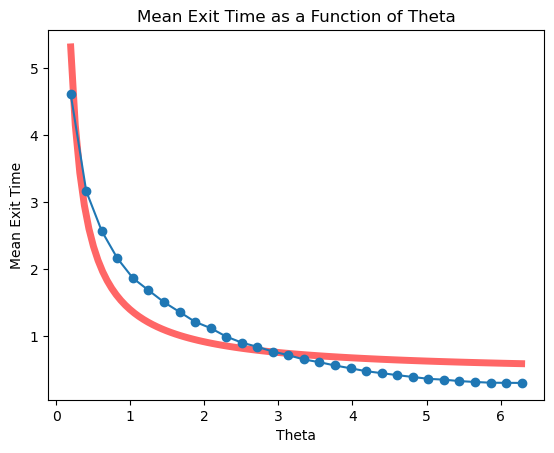

In [285]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear_with_curvefit(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

### Hypothesis and Analysis


- **Overfitting in $\left[0, 2\pi\right]$:** The initial fit might be overly influenced by the data points in the smaller range, leading to a less accurate asymptotic behavior.
- **Expanding the Range:** By considering a larger range for $\theta$, the fitting process can better capture the overall trend, including the horizontal asymptote, resulting in a more accurate representation of the mean exit time.

This approach aims to reduce overfitting and improve the generalization of the fitted function to accurately describe the mean exit time as a function of $\theta$.


0.9393020031843846 0.2755077730370878
Time taken to run simulation with different theta values: 36.72853183746338 seconds
[4.680448999999961, 2.35597799999998, 1.7114829999999892, 1.3117439999999945, 1.0337549999999973, 0.8473549999999989, 0.6761969999999997, 0.565031, 0.47027400000000014, 0.3995010000000002, 0.3416500000000001, 0.30870600000000015, 0.2942590000000001, 0.2953540000000001, 0.2941470000000001, 0.2964810000000001, 0.2926560000000001, 0.29368200000000017, 0.29418100000000014, 0.2932300000000001, 0.2947230000000001, 0.29391100000000003, 0.29388700000000006, 0.29407300000000014, 0.2957760000000001, 0.29615900000000006, 0.29306900000000013, 0.29628000000000004, 0.2981710000000001, 0.2952000000000002, 0.29435300000000014, 0.29304400000000014, 0.29749600000000015, 0.29730600000000007, 0.2950570000000002, 0.2943300000000001, 0.29487600000000014, 0.29607900000000015, 0.2952470000000001, 0.29657400000000017, 0.3025850000000001, 0.29606800000000016, 0.2947410000000001, 0.2941640000

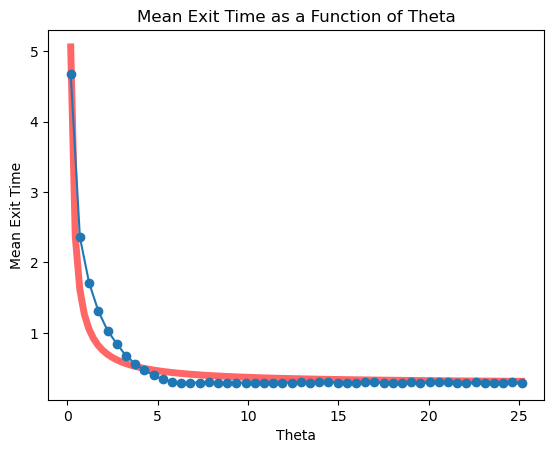

In [288]:
# run simulation with different theta values
L = 8 *np.pi
theta_values = np.linspace(np.pi/16, L, 50)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear_with_curvefit(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, L, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

We see that using a wider ranges of $\theta$-s give us a quite statisfying approximation for our data. The approximation is not perfect and it is probable that the underlying function is more complex, however we stop our research here.

# Fitting Levy Distribution to Time Histogram

The histogram represents the distribution of exit times for particles with a fixed $\theta$. It visualizes how frequently particles escape the circular region at different times.
### Expected Behavior

- **Initial Phase:** At the beginning, the rate is low because particles haven't reached the exit segment yet. As time progresses, more particles find the exit.
- **Peak and Decline:** The histogram peaks as the maximum number of particles escape around a certain time and then declines as fewer particles remain in the circle.
### Distribution Characteristics

- **Poisson-like Distribution:** The expected shape is similar to a Poisson distribution, indicating the probability of particles escaping over time. However, it has a heavier tail, suggesting that some particles take significantly longer to escape.
- **Empirical Fit:** Through empirical observation, we find that the Levy distribution fits the histogram best.
### Connection Between Levy Distribution and Brownian Motion

- **Levy Distribution:** This is a probability distribution that describes the step lengths of a random walk, where the steps follow a heavy-tailed distribution. This means that while most steps are small, there are occasional large steps.
- **Brownian Motion:** Brownian motion, or a random walk, is a path consisting of a succession of random steps. The Levy distribution models the time intervals between these steps, capturing the long tails observed in the histogram.
The Levy distribution is a stable distribution, and one of the few that is stable under addition. This makes it suitable for modeling the time between events in Brownian motion, as it accurately represents the heavy-tailed nature of the distribution of exit times.


In [162]:
mean_exit_times_tmp = [simulate_particle(E(r = 1., T_lim = 20.)) for _ in range(10000)]
mean_exit_times_tmp = [val for val in mean_exit_times_tmp if val is not None]
mean_exit_time_tmp = np.mean(mean_exit_times)
print(f"Mean exit time (discretized with Brownian motion and elastic reflection): {mean_exit_time}")

Mean exit time (discretized with Brownian motion and elastic reflection): 2.2279219999999818


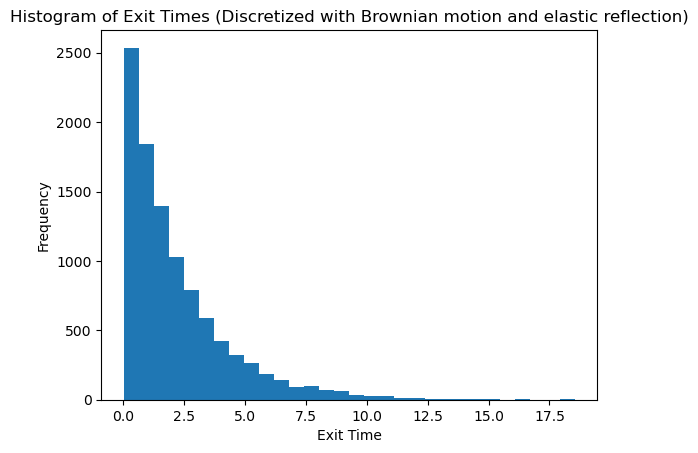

In [163]:
# Plot histogram of exit times
plt.hist(mean_exit_times_tmp, bins=30)
plt.xlabel('Exit Time')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Times (Discretized with Brownian motion and elastic reflection)')
plt.show()

0.7189944278186888 -0.009977055599261802


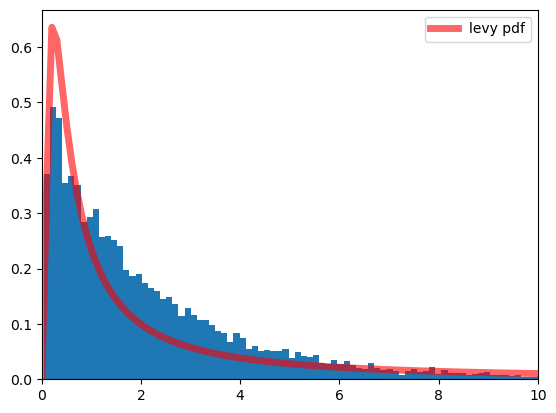

In [166]:
from matplotlib.pylab import norm
from scipy.stats import levy

loc, scale = levy.fit(mean_exit_times_tmp)
print(scale, loc)
x = np.linspace(0, 10, 100)
plt.xlim(0, 10)
plt.plot(x, levy.pdf(x, loc = loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='levy pdf')
plt.hist(mean_exit_times_tmp, bins=150, density = True)
plt.legend()
plt.show()

### Analysis of the Plot

- **Initial Alignment:** The Levy distribution starts high, aligning well with the initial steep rise in the histogram, capturing the early escape times accurately.
- **Peak and Tail Fit:** The distribution fits well with the peak and the heavy tail of the histogram, indicating that it models the probability of longer escape times effectively.
- **Overall Fit Quality:** The Levy distribution provides a robust fit across the entire range of exit times, confirming its appropriateness for this data.

In conclusion, the Levy distribution's heavy tail and flexibility make it an excellent fit for modeling the exit times of particles undergoing Brownian motion, capturing both the initial rise and the long tail observed in the empirical data.

# Density Plots


- **Simulation of Particle Distribution:** Here, we simulate several particles and observe how they are distributed across the region over time.
- **Initial Concentration:** Initially, the particles are concentrated around the starting point. This represents the initial conditions of the simulation where all particles begin at the same location.
- **Spreading Out:** As time progresses, the particles spread out due to Brownian motion. This spreading illustrates the diffusion process as particles move randomly.
- **Graphical Representation:** The density plots visually represent this process, showing the initial concentration and subsequent spreading of particles across the region.

These density plots provide a visual understanding of the diffusion dynamics of particles, highlighting how their distribution evolves over time.


In [23]:
# In parallel simulation basically and scatter plot at each step. 

from re import I


def make_snapshot(experiment, coords, escaped_coords, mode = 'scatter'):
    # Parameters
    r = experiment.r  # Radius of the circle
    theta = experiment.r  # Angle of the missing arc in radians (e.g., 45 degrees)
    margin = 0.5

    # Get x and y 
    x = np.array([_[0] for _ in coords])
    y = np.array([_[1] for _ in coords])
    x_esc = np.array([_[0] for _ in escaped_coords])
    y_esc = np.array([_[1] for _ in escaped_coords])
    
    # Create the plot
    fig, ax = plt.subplots()

    if mode == 'scatter':
        # Scatter plot of the points
        ax.scatter(x, y, label='Data points')
        ax.scatter(x_esc, y_esc, label='Escaped data points', color = 'red')
    else: 
        x_full = np.concatenate((x, x_esc))
        y_full = np.concatenate((y, y_esc))
        # Create the heatmap
        heatmap, xedges, yedges = np.histogram2d(x_full, y_full, bins=50, range=[[-r - margin, r + margin], [-r - margin, r + margin]])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # Plot the heatmap
        cax = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', aspect='auto')

        # Add a colorbar
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label('Frequency')

    # Define the circle with a missing arc
    theta_start = theta / 2.  # Start angle for the arc (in radians)
    theta_end = 2 * np.pi - theta / 2.  # End angle for the arc (in radians)

    # Create the solid arc
    arc_solid = np.linspace(theta_start, theta_end, 100)
    circle_x_solid = r * np.cos(arc_solid)
    circle_y_solid = r * np.sin(arc_solid)

    # Create the dotted arc for the missing segment
    arc_dotted = np.linspace(theta_end, 2 * np.pi + theta_start, 100)
    circle_x_dotted = r * np.cos(arc_dotted)
    circle_y_dotted = r * np.sin(arc_dotted)

    # Plot the solid arc
    ax.plot(circle_x_solid, circle_y_solid, color='y', label=f'Circle with radius {r} and missing arc of {theta * 180 / np.pi:.1f}°')

    # Plot the dotted arc
    ax.plot(circle_x_dotted, circle_y_dotted, 'g--', label='Missing arc')

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set the limits to create a box from (-r, -r) to (r, r)
    ax.set_xlim(-r - margin, r + margin)
    ax.set_ylim(-r - margin, r + margin)

    # Add grid lines for better visualization
    ax.grid(True)

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def simulate_particle_with_snapshots(experiment, snapshot_steps, mode = 'scatter'):
    # Start at the center
    coords = [(experiment.x_start, experiment.y_start)] * experiment.num_particles
    escaped_coords = []
    time = 0.0
    step = 0
    max_step = np.max(snapshot_steps)
    
    D = experiment.D 
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r 

    while step < max_step:
        new_coords = []
        new_escaped_coords = []
        for (i, (x, y)) in enumerate(escaped_coords):
            x, y = brownian_step_escaped(x, y, experiment)
            escaped_coords[i] = (x, y)
        for (x, y) in coords:
            x, y = brownian_step(x, y, experiment)  
            if x**2 + y**2 <= r**2:      
                new_coords.append((x, y))
            else:
                escaped_coords.append((x, y))
        time += dt
        step += 1
        coords = new_coords
        if step in snapshot_steps:
            print(f'Snapshot at time t = {round(time, 3)}:')
            make_snapshot(experiment, coords, escaped_coords, mode)
    return None

Snapshot at time t = 0.01:


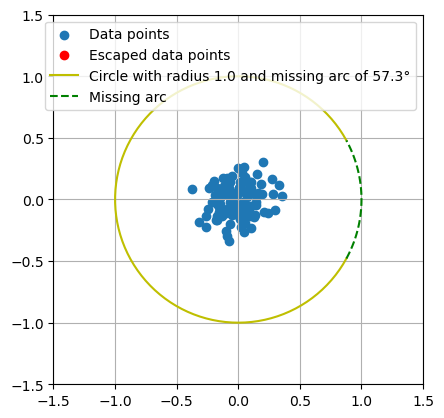

Snapshot at time t = 0.06:


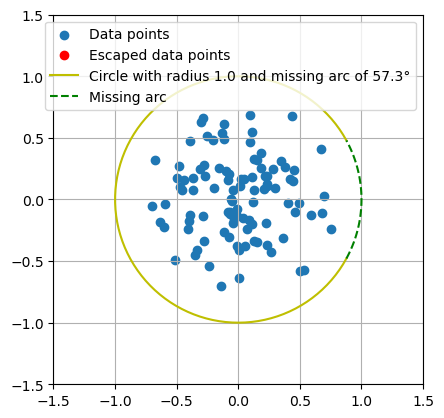

Snapshot at time t = 0.11:


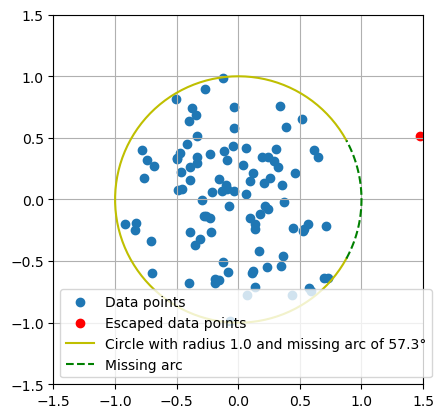

Snapshot at time t = 0.16:


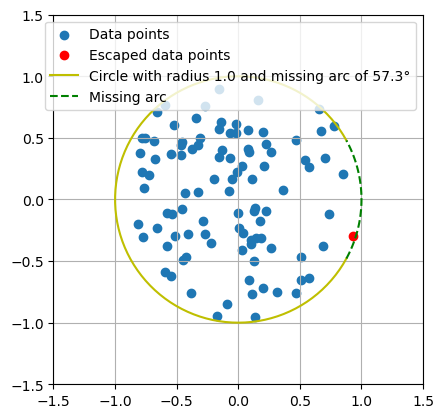

Snapshot at time t = 0.21:


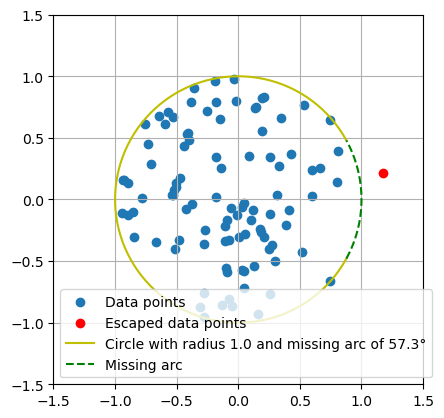

Snapshot at time t = 0.26:


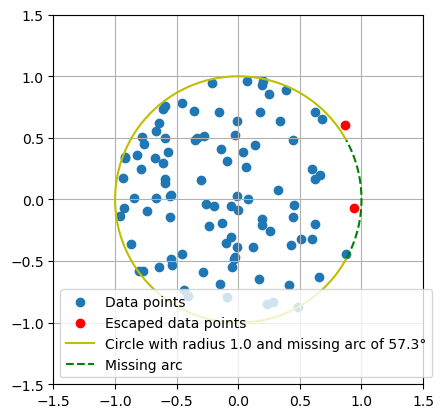

Snapshot at time t = 0.31:


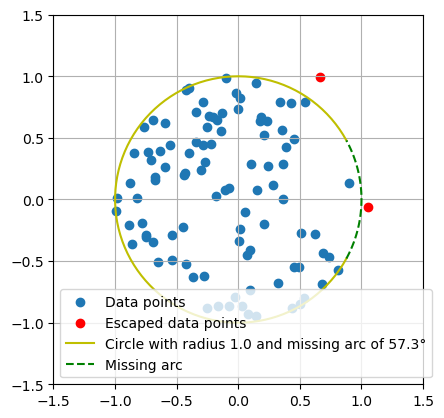

Snapshot at time t = 0.36:


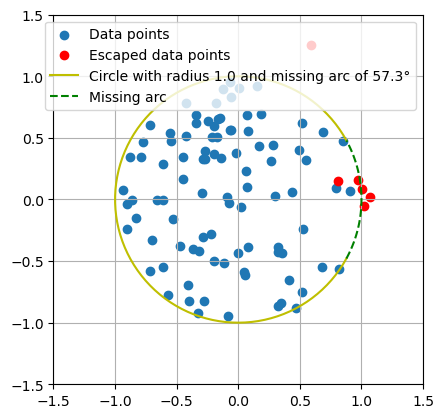

Snapshot at time t = 0.41:


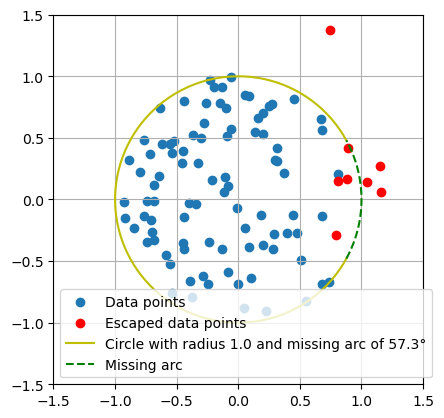

Snapshot at time t = 0.46:


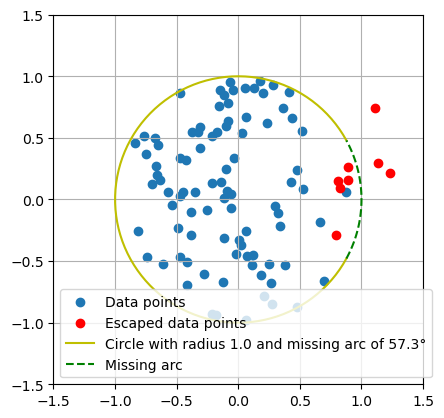

Snapshot at time t = 0.51:


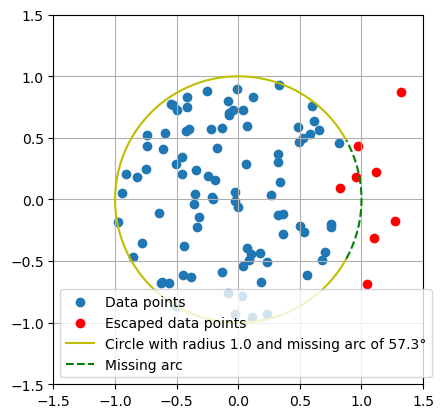

Snapshot at time t = 0.56:


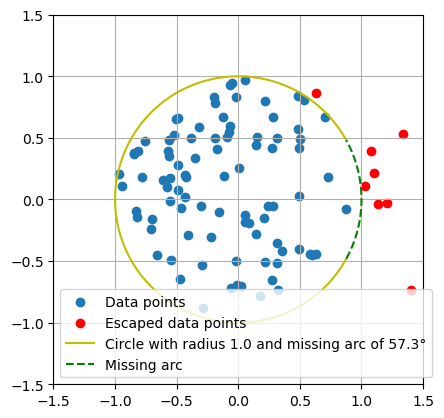

Snapshot at time t = 0.61:


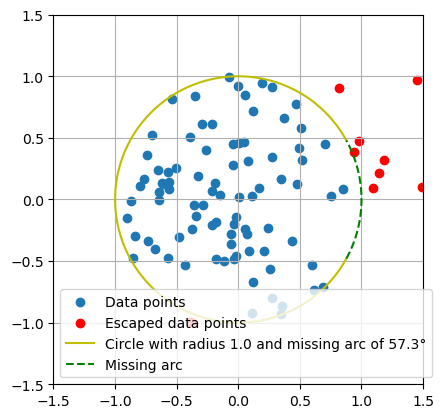

Snapshot at time t = 0.66:


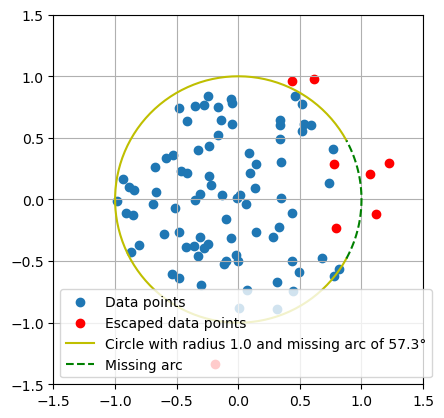

Snapshot at time t = 0.71:


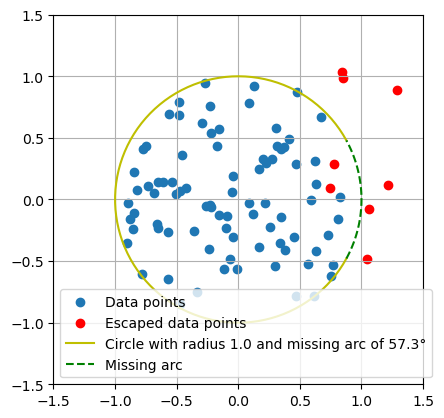

Snapshot at time t = 0.76:


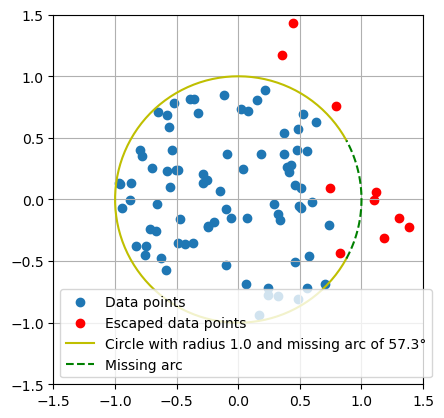

Snapshot at time t = 0.81:


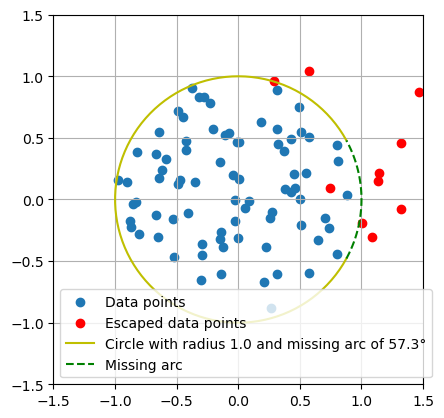

Snapshot at time t = 0.86:


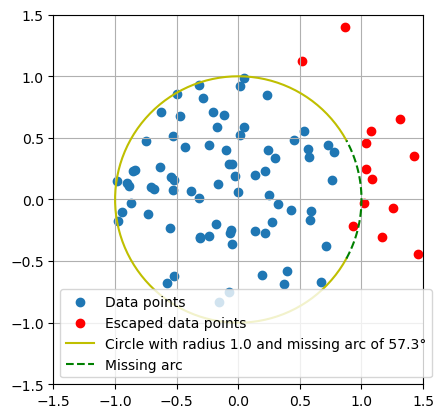

Snapshot at time t = 0.91:


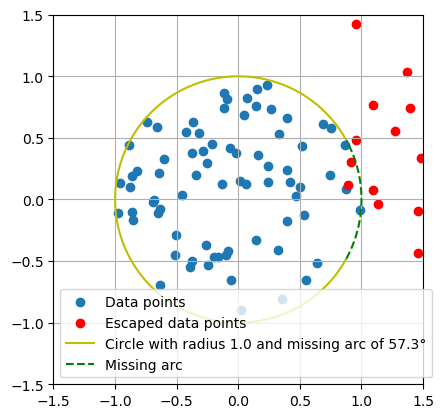

Snapshot at time t = 0.96:


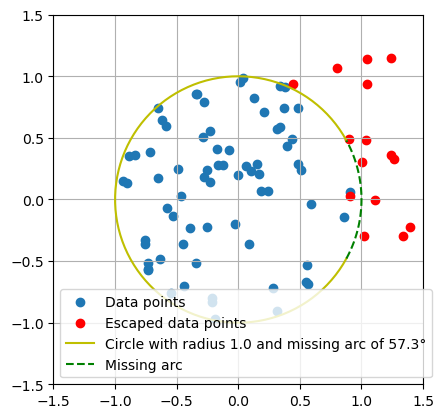

In [24]:
simulate_particle_with_snapshots(E(num_particles=100), range(1, 100, 5))

Snapshot at time t = 0.01:


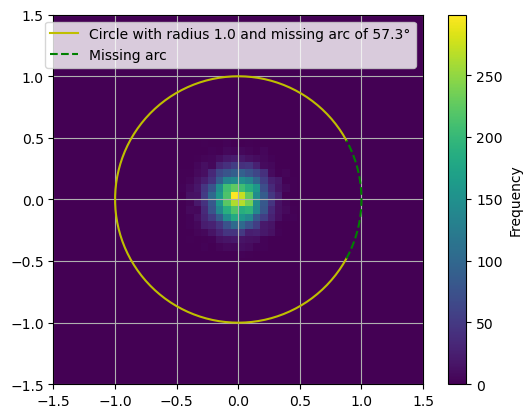

Snapshot at time t = 0.06:


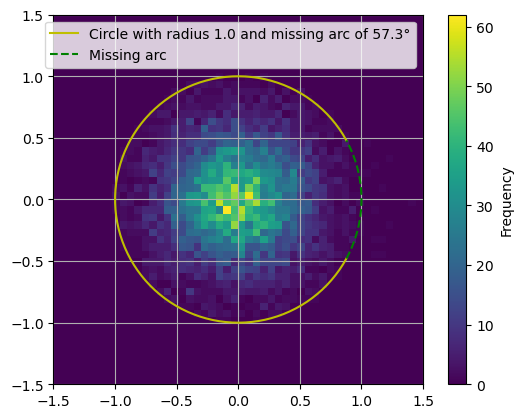

Snapshot at time t = 0.11:


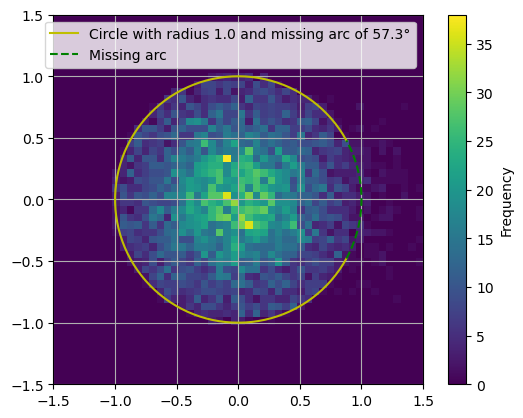

Snapshot at time t = 0.16:


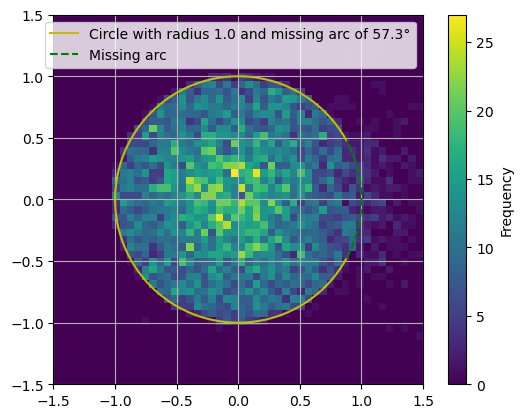

Snapshot at time t = 0.21:


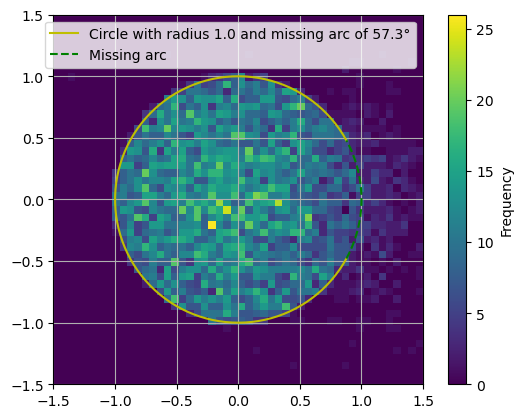

Snapshot at time t = 0.26:


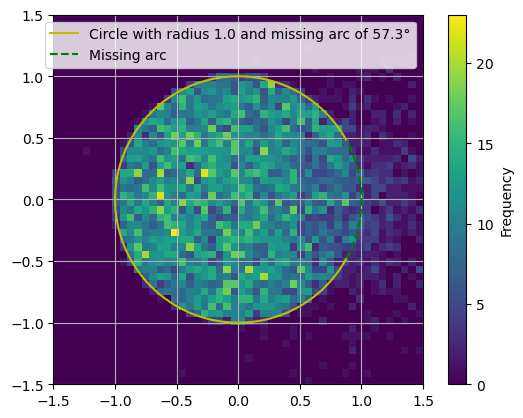

Snapshot at time t = 0.31:


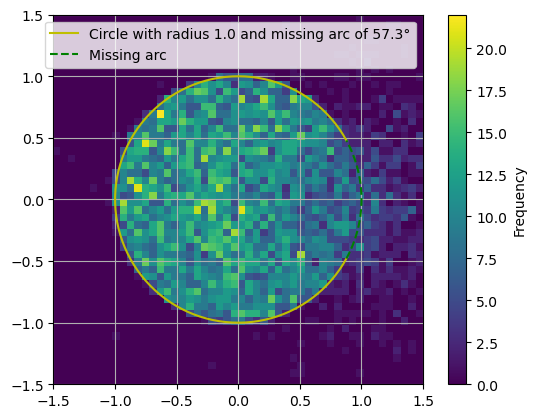

Snapshot at time t = 0.36:


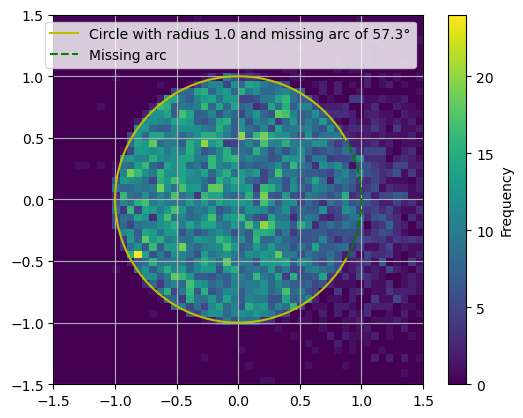

Snapshot at time t = 0.41:


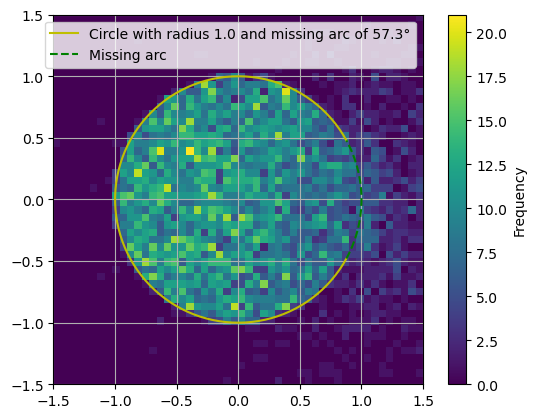

Snapshot at time t = 0.46:


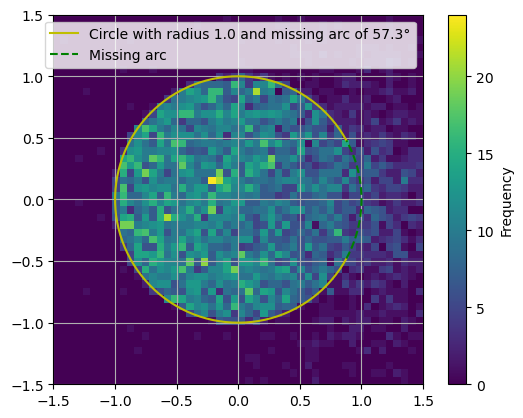

Snapshot at time t = 0.51:


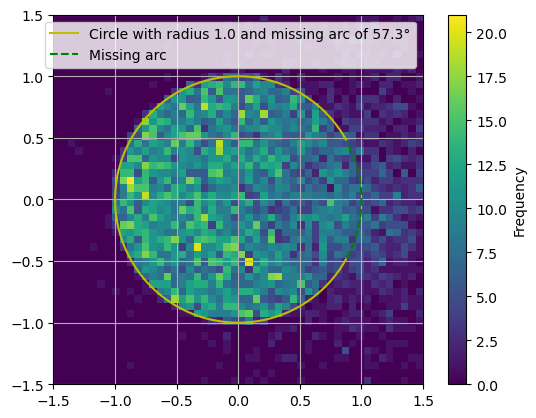

Snapshot at time t = 0.56:


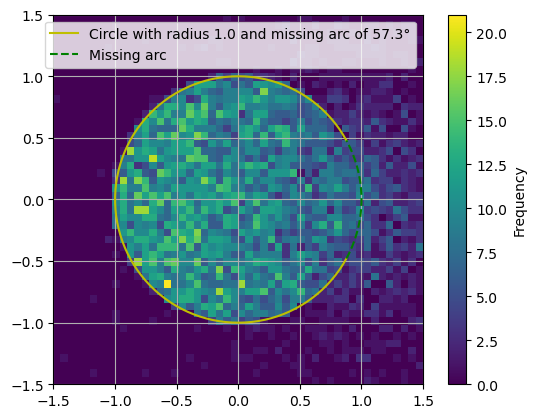

Snapshot at time t = 0.61:


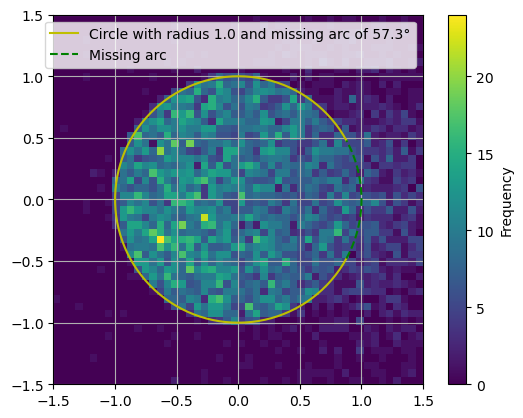

Snapshot at time t = 0.66:


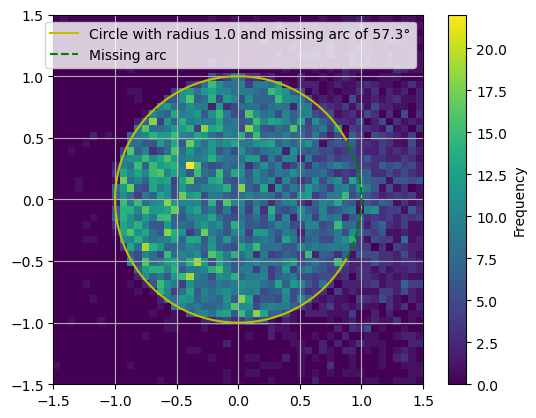

Snapshot at time t = 0.71:


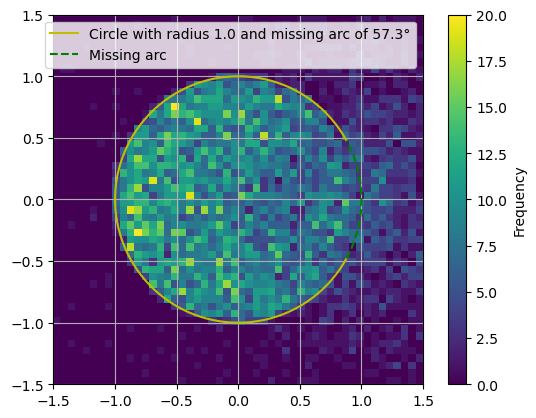

Snapshot at time t = 0.76:


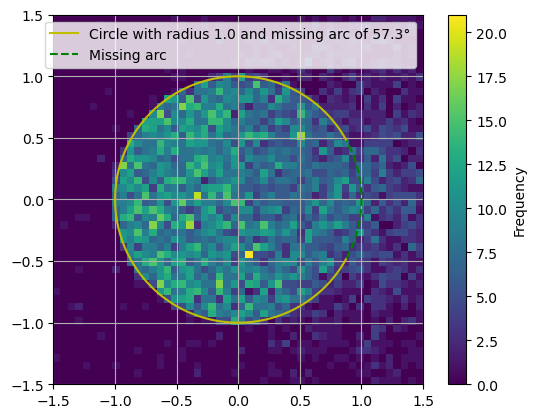

Snapshot at time t = 0.81:


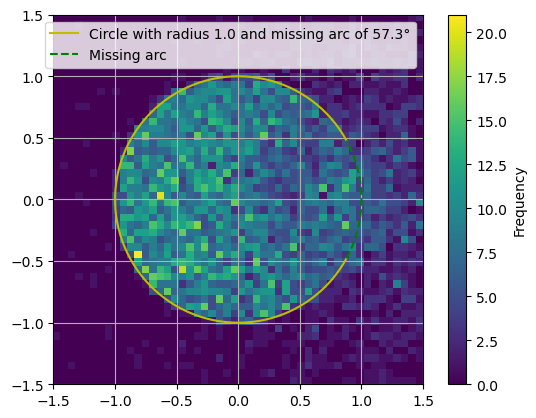

Snapshot at time t = 0.86:


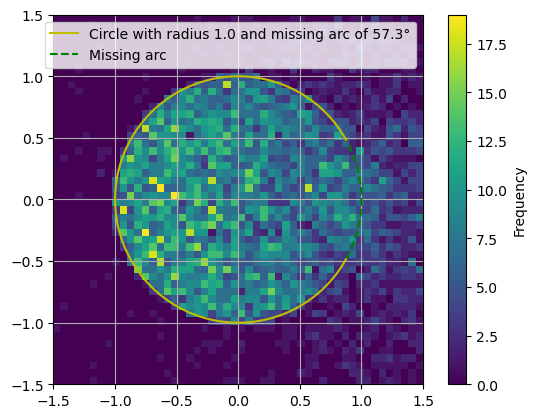

Snapshot at time t = 0.91:


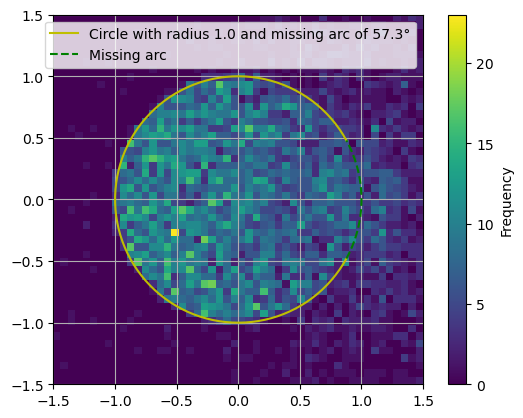

Snapshot at time t = 0.96:


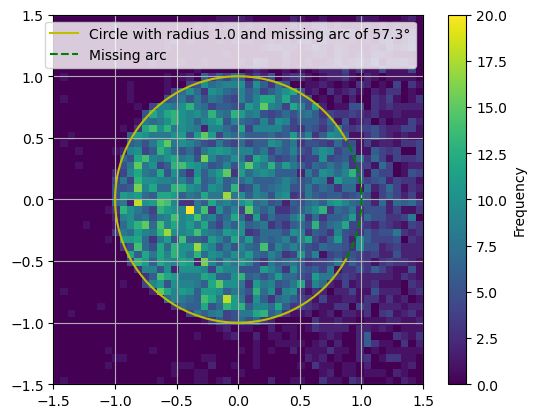

In [25]:
simulate_particle_with_snapshots(E(num_particles=10000), range(1, 100, 5), mode = 'heatmap')

From a position (0.5, 0.5)

Snapshot at time t = 0.01:


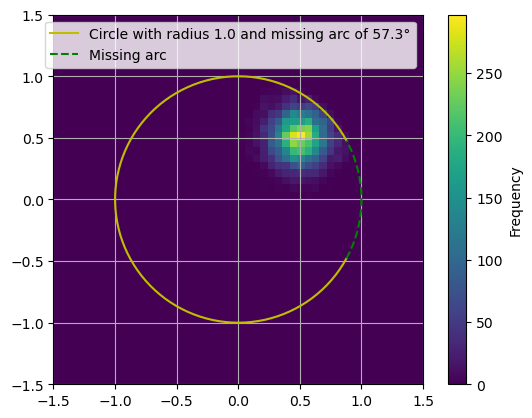

Snapshot at time t = 0.06:


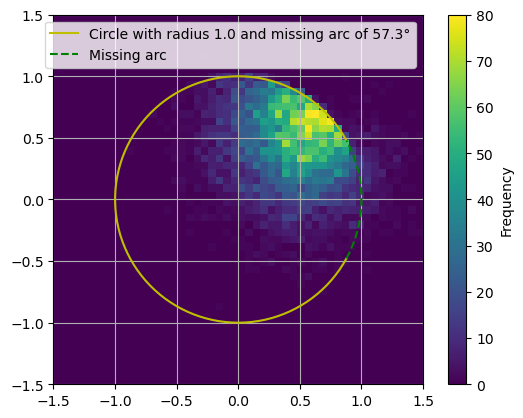

Snapshot at time t = 0.11:


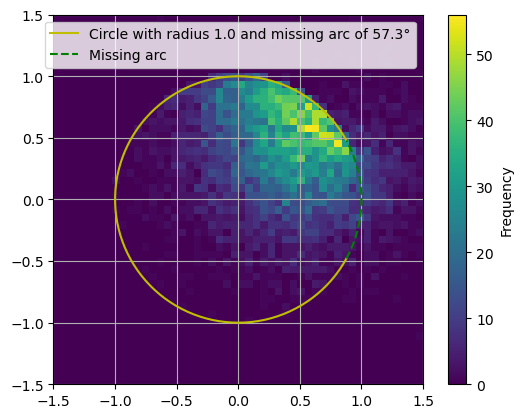

Snapshot at time t = 0.16:


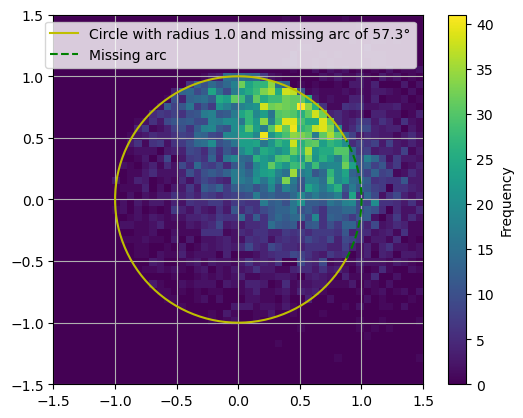

Snapshot at time t = 0.21:


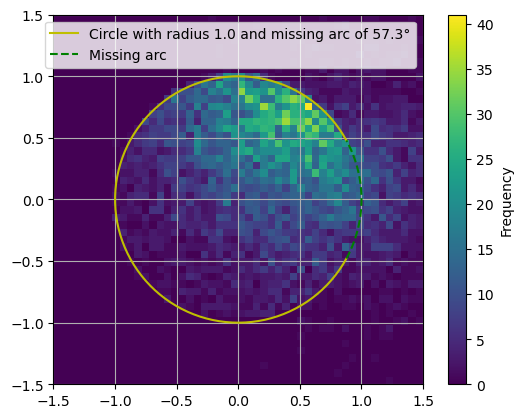

Snapshot at time t = 0.26:


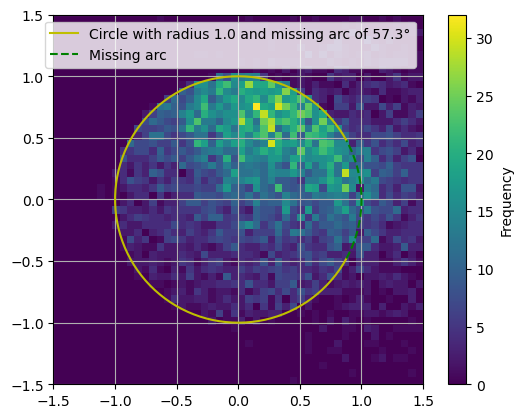

Snapshot at time t = 0.31:


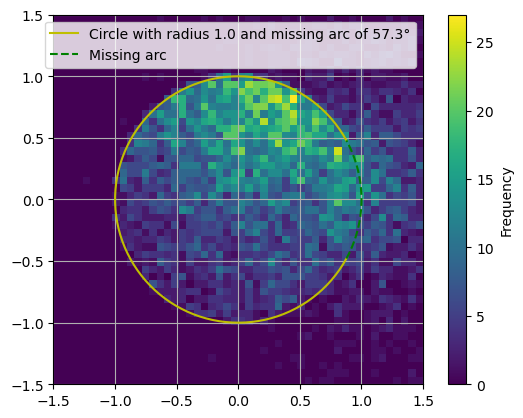

Snapshot at time t = 0.36:


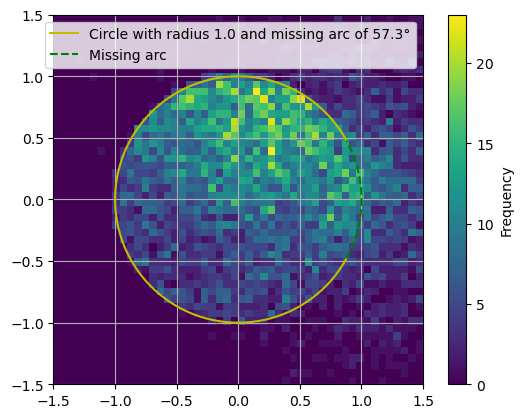

Snapshot at time t = 0.41:


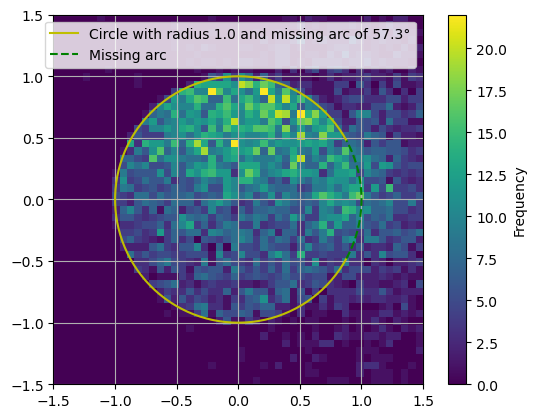

Snapshot at time t = 0.46:


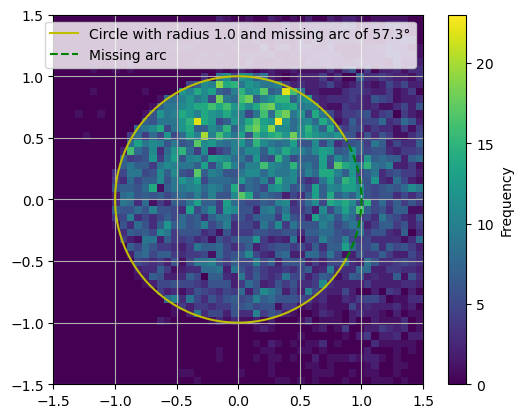

Snapshot at time t = 0.51:


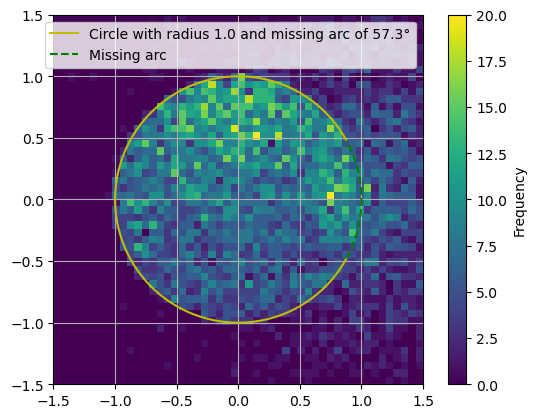

Snapshot at time t = 0.56:


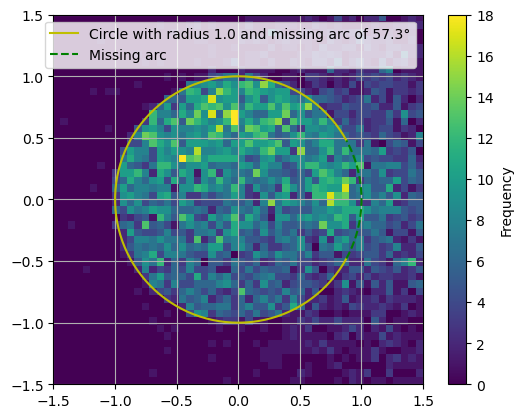

Snapshot at time t = 0.61:


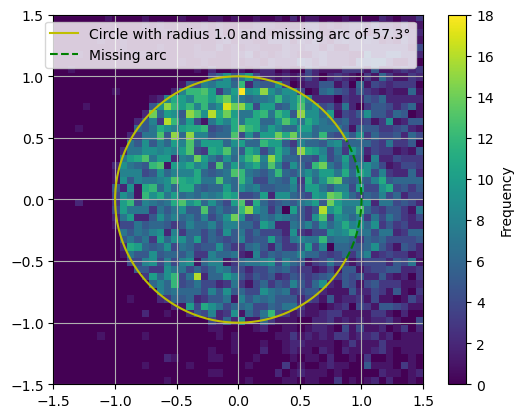

Snapshot at time t = 0.66:


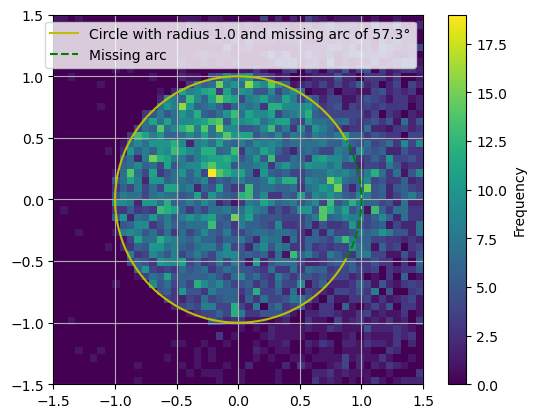

Snapshot at time t = 0.71:


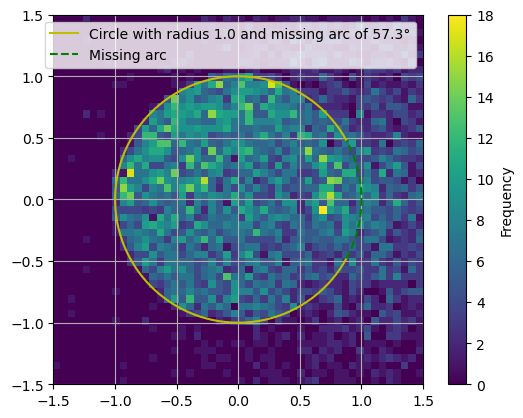

Snapshot at time t = 0.76:


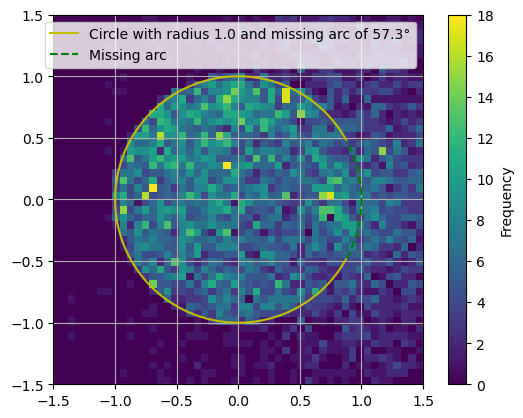

Snapshot at time t = 0.81:


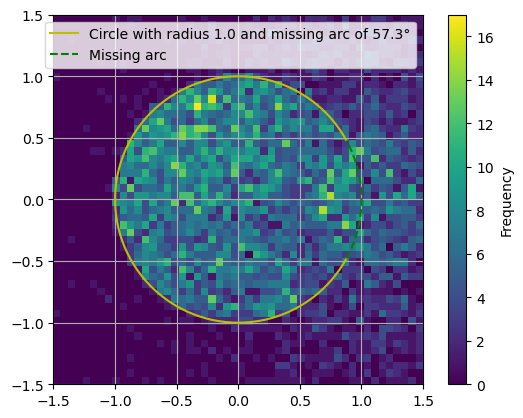

Snapshot at time t = 0.86:


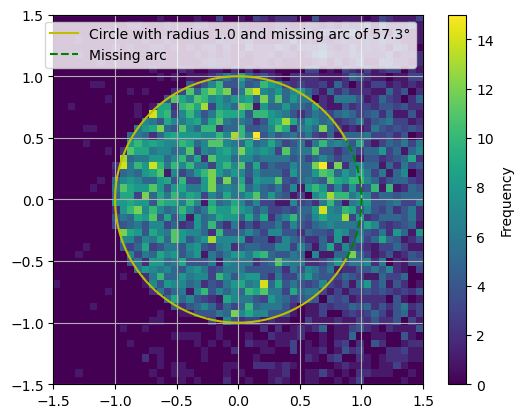

Snapshot at time t = 0.91:


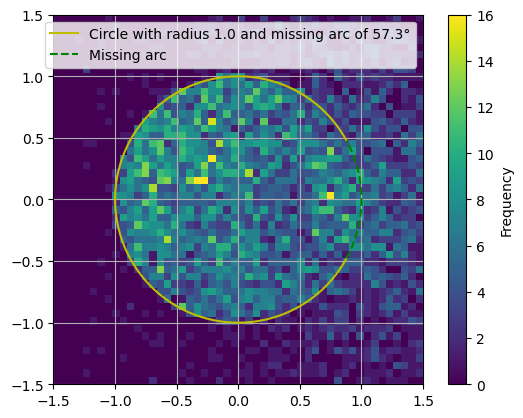

Snapshot at time t = 0.96:


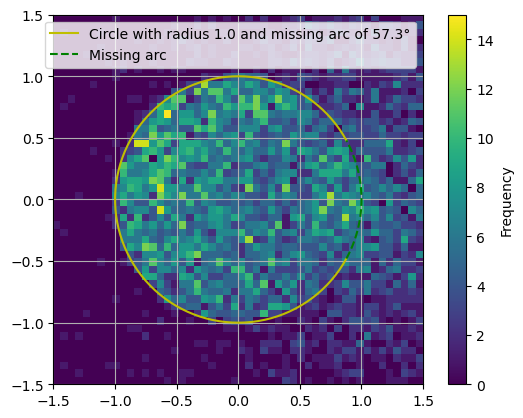

In [26]:
simulate_particle_with_snapshots(E(num_particles=10000, x_start = 0.5, y_start = 0.5), range(1, 100, 5), mode = 'heatmap')

<div style="text-align: center; font-family: 'Georgia', serif; color: #4b0082; padding: 20px; border: 2px solid #4b0082; border-radius: 10px; background-color: #f0f8ff;">
    <h1 style="font-size: 2.5em;">🌟 Thank You for Reading! 🌟</h1>
    <p style="font-size: 1.2em;">We appreciate your time and hope you found the insights valuable.</p>
    <p style="font-size: 1.2em;">For more information or further inquiries, feel free to reach out.</p>
    <p style="font-size: 1.5em; font-style: italic;">Happy Analyzing! 📊</p>
</div>
